In [1]:
from dataloader import *
from model import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd

2024-01-11 14:55:58.934093: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 14:55:58.963587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 14:55:59.217127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 14:56:01.136227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(38)

## Load data

In [41]:
for x,y in test_loader :
    print(x)
    print(y)
    break 

tensor([[[ 0.2744,  0.4119,  0.4485,  ..., -0.8210,  0.1686, -0.9860],
         [ 0.2974,  0.0900,  0.3972,  ..., -0.9395,  0.2170, -1.0091],
         [ 0.1709,  0.0579,  0.3523,  ..., -0.8504,  0.2170, -1.0091],
         ...,
         [ 0.2169,  0.3475,  0.3716,  ..., -0.1346,  0.5032, -0.8936],
         [ 0.3549,  0.7015,  0.4678,  ..., -0.4029,  0.2640, -0.8705],
         [ 0.0676,  0.0579,  0.2242,  ..., -0.7613,  0.0732, -0.8782]],

        [[ 0.2974,  0.0900,  0.3972,  ..., -0.9395,  0.2170, -1.0091],
         [ 0.1709,  0.0579,  0.3523,  ..., -0.8504,  0.2170, -1.0091],
         [ 0.4929,  0.5406,  0.5319,  ..., -0.4626,  0.4078, -0.9398],
         ...,
         [ 0.3549,  0.7015,  0.4678,  ..., -0.4029,  0.2640, -0.8705],
         [ 0.0676,  0.0579,  0.2242,  ..., -0.7613,  0.0732, -0.8782],
         [ 0.1479,  0.0900,  0.2561,  ..., -0.5517,  0.2640, -0.8397]],

        [[ 0.1709,  0.0579,  0.3523,  ..., -0.8504,  0.2170, -1.0091],
         [ 0.4929,  0.5406,  0.5319,  ..., -0

In [3]:
ETTh1_data = pd.read_csv('data/ETTh1.csv', header=None).to_numpy()

In [4]:
ETTh1_data.shape

(17420, 7)

In [5]:
batch_size = 32
n_train = 8545
n_eval = 2881
n_test = 2881
train_loader, eval_loader, test_loader = get_loaders(ETTh1_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

train_data  (8737, 7)


In [6]:
cpt = 0
for x,y in test_loader : 
    cpt += x.shape[0]
print(cpt)

2881


## Train

In [7]:
import torch
import torch.nn as nn

class Embedding_inverted(nn.Module):
    def __init__(self, T, D):
        super(Embedding_inverted, self).__init__()
        self.emb = nn.Linear(T, D)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = x.permute(0,2,1)
        x_emb = self.emb(x)
        return self.dropout(x_emb)

class FeedForward(nn.Module):
    def __init__(self, D):
        super(FeedForward, self).__init__()
        self.feed_forward = nn.Sequential(
          nn.Linear(D, D),
          nn.GELU(),
          nn.Dropout(0.1),
          nn.Linear(D, D), 
        )

    def forward(self, x):
        #x = x.permute(0,2,1)
        x = self.feed_forward(x)
        #x = x.permute(0,2,1)
        return x
    
class Attention(nn.Module):
    def __init__(self, D, proj_dim, nb_head=8):
        super(Attention, self).__init__()
        self.query_projection = nn.Linear(D, proj_dim)
        self.key_projection = nn.Linear(D, proj_dim)
        self.value_projection = nn.Linear(D, proj_dim)
        self.out_projection = nn.Linear(proj_dim, D)
        self.H = nb_head

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.H

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = 1. / torch.sqrt(torch.tensor(E))

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        A = torch.softmax(scale * scores, dim=-1)
        V = torch.einsum("bhls,bshd->blhd", A, values)

        out = V.reshape(B,L,-1)

        return self.out_projection(out)
        

class TrmBlock(nn.Module):
    def __init__(self, N, D, proj_dim):
      super(TrmBlock, self).__init__()

      self.multivariate_attention= Attention(D, proj_dim)
      #self.multivariate_attention = nn.MultiheadAttention(D, num_heads=8)
      self.layer_norm1 = nn.LayerNorm(D)
      self.feed_forward = FeedForward(D)
      self.layer_norm2 = nn.LayerNorm(D)

    def forward(self, x):
      att = self.multivariate_attention(x,x,x)
      x = self.layer_norm1(x + att)
      #print("x_norm  : ", x.shape)
      #print("permute : ", xT.shape)
      x_forward = self.feed_forward(x)
      x= self.layer_norm2(x + x_forward)
      return x


class iTransformer(nn.Module):
    def __init__(self, N, T, D, S, proj_dim, num_blocks):
      super(iTransformer, self).__init__()

      self.embedding = Embedding_inverted(T, D)
      self.trmblock = nn.ModuleList([TrmBlock(N, D, proj_dim) for _ in range(num_blocks)])
      self.projection = nn.Linear(D, S, bias=True)

    def forward(self, x):
      #print("x : ",x.shape)
      x = self.embedding(x)
      #print('emb : ',x.shape)
      for block in self.trmblock:
            x = block(x)
      #print('trmblock : ',x.shape)
      y = self.projection(x)
      #print('proj : ', y.shape)
      y=y.permute(0,2,1)
      #print('final : ', y.shape)
      return y

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#writer = SummaryWriter()

cpu


In [9]:
N = 7 #nb variables
T = 96 #input length (lookback window)
D = 512 # 256 ou 512
S = 96 # 96 ou 192, 336, 720
proj_dim = 128
num_blocks = 4 #2 ou 3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(N, T, D, S, proj_dim, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-3, weight_decay=1e-5) #10−3, 5 × 10−4, 10−4 


In [10]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, test_loader, 10, device)

---- epoch :  0
loss train : 0.3814197286073841
loss eval : 0.49985157379082273
---- epoch :  1
loss train : 0.3244834011837618
loss eval : 0.4692702136196933
---- epoch :  2
loss train : 0.3116307419293852
loss eval : 0.4916923984393969
---- epoch :  3
loss train : 0.30397350101995824
loss eval : 0.45806479175667186
---- epoch :  4
loss train : 0.3058021515607834
loss eval : 0.5199921357107686
---- epoch :  5
loss train : 0.3154400696060551
loss eval : 0.526614486516177
---- epoch :  6
loss train : 0.33161837907869424
loss eval : 0.5171642372241387
---- epoch :  7
loss train : 0.34531694839694604
loss eval : 0.4459979026527195
---- epoch :  8
loss train : 0.3048924584664516
loss eval : 0.4458085270700874
---- epoch :  9
loss train : 0.29650388624685914
loss eval : 0.46288290996472914


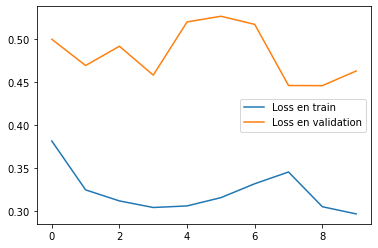

In [11]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

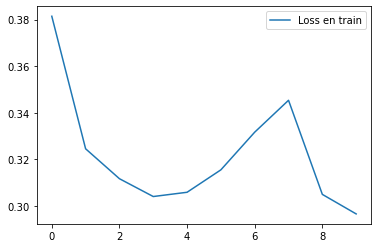

In [12]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.legend()
plt.show()

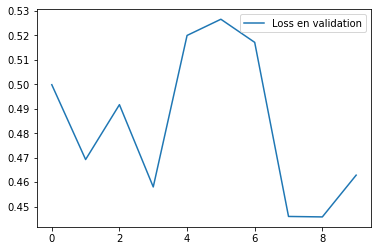

In [13]:
plt.figure()
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

## Test

In [14]:
loss_test, loss_mae, target, yhat = test(itransformer, test_loader, device)
print("MSE : ", loss_test)
print("MAE : ", loss_mae)

MSE :  0.46288290996472914
MAE :  0.4745509650681045


Affichage pour une modalité sur toute la durée de la prédiction

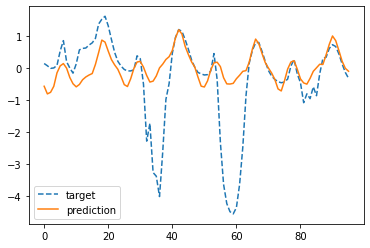

In [15]:
i = 0
plt.figure()
plt.plot(target[0,:,i].to("cpu"), "--", label="target")
plt.plot(yhat[0,:,i].to("cpu"),label="prediction")
plt.legend()
plt.show()

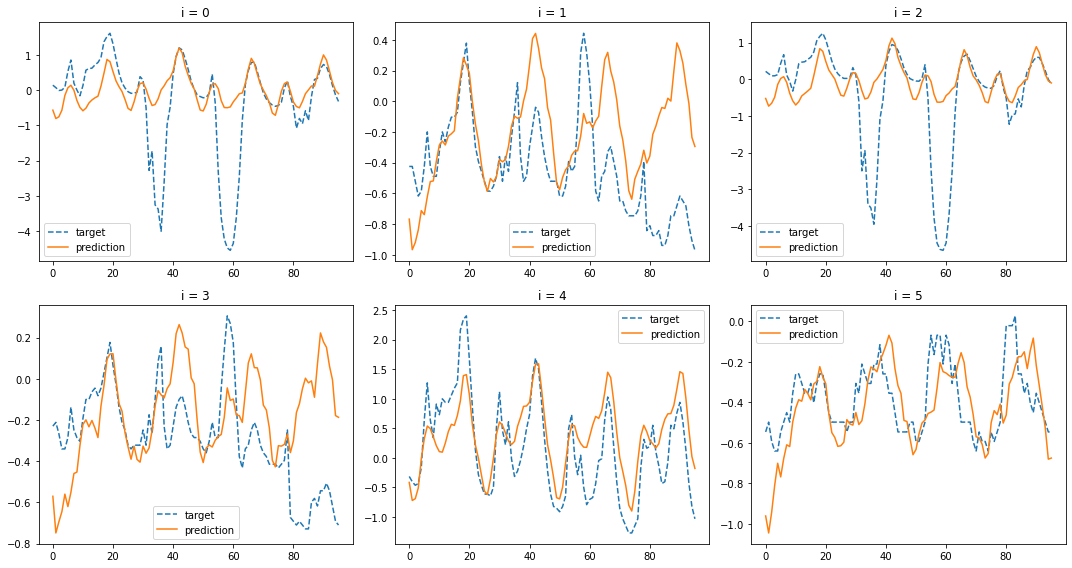

In [40]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    current_i = i - 1
    
    plt.plot(target[0, :, current_i].to("cpu"), "--", label="target")
    plt.plot(yhat[0, :, current_i].to("cpu"), label="prediction")
    
    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

Affichage de toutes les modalités à un instant t

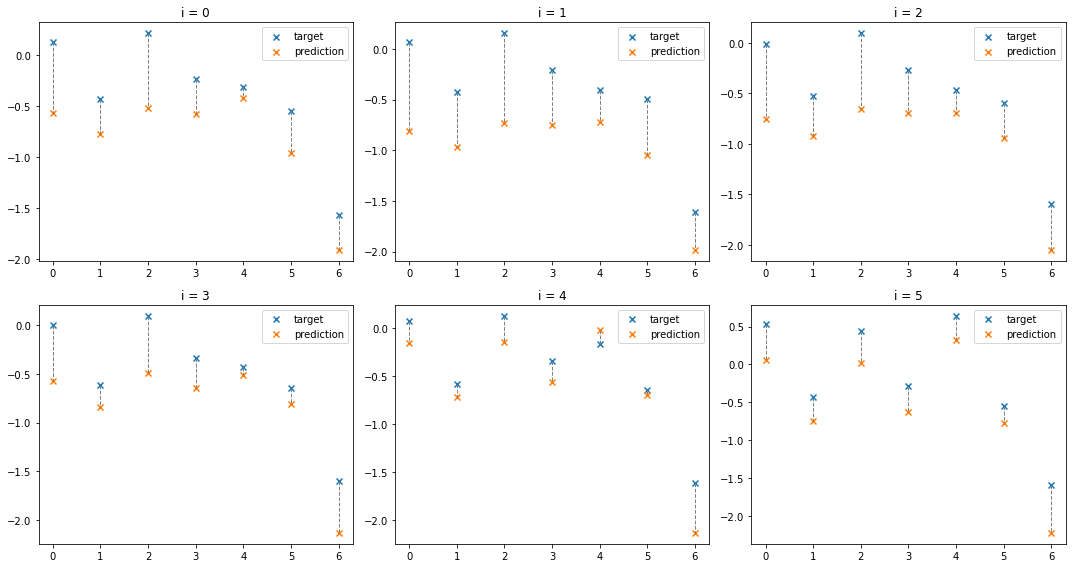

In [39]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    
    current_i = i - 1
    
    plt.scatter(np.arange(len(target[0, current_i, :])), target[0, current_i, :].to("cpu"), marker='x', label="target")
    plt.scatter(np.arange(len(target[0, current_i, :])), yhat[0, current_i, :].to("cpu"), marker='x', label="prediction")

    for j in range(len(target[0, 0, :])):
        plt.plot([j, j], [target[0, current_i, j].to("cpu"), yhat[0, current_i, j].to("cpu")], color='gray', linestyle='--', linewidth=1)

    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()